# An OpenDSS Python Interface
Author: Ran Zhu @SEU https://github.com/RanZhu1989

This package is an OpenDSS Python Interface. It is a wrapper of OpenDSS Direct DLL. The package is developed based on the OpenDSSdirect Project (https://github.com/dss-extensions/OpenDSSDirect.py). The purpose of this package is to provide a convenient way to use OpenDSS in Python, especially for operating data generating and reinforcement learning. The package is still under development. Any suggestions are welcome.

In [1]:
import opendssdirect as dss
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import sys
from typing import Tuple
import netCDF4 as nc

In [2]:
"""DSS Model Class """

class DSS_Model():
    
    def __init__(self,main_file_path:str) -> None:
        dss.Text.Command("Redirect " + main_file_path) # Compile and build DSS model from source file
        self.df_line = dss.utils.lines_to_dataframe() # dss.line -> line.df
        self.create_lineGraphData()
        self.physical_graph = [0] * 4 # Graph tuple init
        self.physical_graph[0],self.BusXY = self.create_graph_by_phase(phase=0) # Obtain four graphs: three-phases = 0
        self.physical_graph[1],_ = self.create_graph_by_phase(phase=1) # PhaseA = 1
        self.physical_graph[2],_ = self.create_graph_by_phase(phase=2) # PhaseB = 2
        self.physical_graph[3],_ = self.create_graph_by_phase(phase=3) # PhaseC = 3
        self.df_load = dss.utils.loads_to_dataframe()
        self.list_nodeName = self.NodeNameList()
        self.positions_nodeName = [[index for index, value in enumerate(dss.Circuit.AllNodeNames()) if value in self.list_nodeName[phase]] for phase in range(0, 3)]
        self.list_lineName = self.LineNameList()
        self.position_lineName = [[self.list_lineName[phase].index(elem) if elem in self.list_lineName[phase] else None for elem in dss.Lines.AllNames()] for phase in range(3)]
        pass
    
    """ -------------------- Name lists in openDSS model -----------------------"""
    
    def NodeNameList(self) -> list:        
        nodeName = [dss.Circuit.AllNodeNamesByPhase(phase) for phase in range(1, 4)]
        
        return nodeName
    
    def LineNameList(self) -> list:
        lineName = [0] * 3
        lineName[0] = self.line_graph_data[self.line_graph_data['Phase_A']].index.tolist()
        lineName[1] = self.line_graph_data[self.line_graph_data['Phase_B']].index.tolist()
        lineName[2] = self.line_graph_data[self.line_graph_data['Phase_C']].index.tolist()
        
        return lineName
    
    pass
    
    """-------------------- Model modification --------------------"""
    
    def open_switches_by_phase(self,edges:pd.DataFrame,phase:int=0) -> None:
        for name in edges.index:
            dss.Circuit.SetActiveElement("Line." + name) # Chose active line
            dss.CktElement.Open(0,phase) # Open all terminals at one specified phase. phase=0 means all phases
            
    def close_switches_by_phase(self,edges:pd.DataFrame,phase:int=0) -> None:
        for name in edges.index:
            dss.Circuit.SetActiveElement("Line." + name) # Chose active line
            dss.CktElement.Close(0,phase) # Close all terminals at one specified phase. phase=0 means all phases        
            
    def set_load_P(self,name:str,P:float) -> None:
        if name not in self.df_load.index:
            raise ValueError("load name does not exist")
        dss.Loads.Name(name)
        dss.Loads.kW(P)
        
    def set_load_Q(self,name:str,Q:float) -> None:
        if name not in self.df_load.index:
            raise ValueError("load name does not exist")
        dss.Loads.Name(name)
        dss.Loads.kvar(Q)
    
    pass
    
    """ -------------------- Read snapshot simulation results --------------------"""
    
    def complex_reader(self,complex_data:list) -> list:
        """List = [Real, Imag, Mag, Ang]"""
        out = []
        out = [[complex_data[i], complex_data[i+1], np.abs(complex_data[i] + 1j * complex_data[i+1]),
        np.angle(complex_data[i] + 1j * complex_data[i+1], deg=True)] for i in range(0, len(complex_data), 2)]
        return out
    
    def read_AllNodeVoltage_by_phase(self,phase:int) -> list:
        if phase not in (1,2,3):
            raise ValueError("phase must be 1,2,or 3")
        V = self.complex_reader(dss.Circuit.AllBusVolts())
        nodeV_complex_phase = [V[index] for index in self.positions_nodeName[phase-1]]
        
        return nodeV_complex_phase
    
    def read_LineCurrentMagAng(self,LineName:str) -> list:
        """|    Phase       |    Bus1      |     Bus2   |
            1~3 = Phase_A~B        ( Mag: @A, Ang: Deg )      
        """
        dss.Lines.Name(LineName)
        current = dss.CktElement.CurrentsMagAng()
        Bus1 = current[:len(current)//2]
        Bus1_Mag = Bus1[::2]
        Bus1_Ang = Bus1[1::2]
        Bus2 = current[len(current)//2:]
        Bus2_Mag = Bus2[::2]
        Bus2_Ang = Bus2[1::2]
        phaseOrder = dss.CktElement.NodeOrder() 
        phaseOrder = phaseOrder[:len(phaseOrder)//2]
        LineCurrentMagAng = [[order, mag1, ang1, mag2, ang2] for order, mag1, ang1, mag2, ang2 in zip(phaseOrder, Bus1_Mag, Bus1_Ang, Bus2_Mag, Bus2_Ang)]
        
        return LineCurrentMagAng
    
    def read_LinePowerComplex(self,LineName:str) -> list:
        """|    Phase       |    Bus1      |     Bus2   |
            1~3 = Phase_A~B        ( Real: kW, Imag: kVar )        
        """
        dss.Lines.Name(LineName)
        power = dss.CktElement.Powers()
        Bus1 = power[:len(power)//2]
        Bus1_Real = Bus1[::2]
        Bus1_Imag = Bus1[1::2]
        Bus2 = power[len(power)//2:]
        Bus2_Real = Bus2[::2]
        Bus2_Imag = Bus2[1::2]
        phaseOrder = dss.CktElement.NodeOrder() 
        phaseOrder = phaseOrder[:len(phaseOrder)//2]
        LinePowerMagAng = [[order, mag1, ang1, mag2, ang2] for order, mag1, ang1, mag2, ang2 in zip(phaseOrder, Bus1_Real, Bus1_Imag, Bus2_Real, Bus2_Imag)]
        
        return LinePowerMagAng
    
    def read_AllLineCurrentMagAng(self) -> list:
        LineCurrentMagAng =  [[None]*len(self.list_lineName[p]) for p in range(0,3)] # 0=Bus1_Mag, 1=Bus1_Ang, 2=Bus2_Mag, 3=Bus2_Ang
        for index,line in enumerate(self.df_line.index):
            Current = self.read_LineCurrentMagAng(line) # read current of each line
            if line in self.list_lineName[0]: # if line in phase_A
                temp_current = [item for item in Current if item[0] == 1][0] # find the phase_A data
                LineCurrentMagAng[0][self.position_lineName[0][index]] = temp_current
            
            if line in self.list_lineName[1]:
                temp_current = [item for item in Current if item[0] == 2][0]
                LineCurrentMagAng[1][self.position_lineName[1][index]] = temp_current

            if line in self.list_lineName[2]:
                temp_current = [item for item in Current if item[0] == 3][0]
                LineCurrentMagAng[2][self.position_lineName[2][index]] = temp_current
            pass
        
        return LineCurrentMagAng
    
    def read_AllLinePowerComplex(self) -> list:
        LinePowerComplex =  [[None]*len(self.list_lineName[p]) for p in range(0,3)]
        for index,line in enumerate(self.df_line.index): 
            Power = self.read_LinePowerComplex(line) 
            if line in self.list_lineName[0]: 
                temp_power = [item for item in Power if item[0] == 1][0] 
                LinePowerComplex[0][self.position_lineName[0][index]] = temp_power
            
            if line in self.list_lineName[1]:
                temp_power = [item for item in Power if item[0] == 2][0] 
                LinePowerComplex[1][self.position_lineName[1][index]] = temp_power

            if line in self.list_lineName[2]:
                temp_power = [item for item in Power if item[0] == 3][0] 
                LinePowerComplex[2][self.position_lineName[2][index]] = temp_power
            pass
        
        return LinePowerComplex
    
    def read_AllLosses(self) -> list:
        loss = self.complex_reader(dss.Circuit.AllElementLosses())
        
        return loss
    
    def read_AllRegulators(self) -> list:
        Regulator_tap = [None] * dss.RegControls.Count()
        # you can add more data here
        for index,name in enumerate(dss.RegControls.AllNames()):
            dss.RegControls.Name(name)
            Regulator_tap[index] = dss.RegControls.TapNumber()
            
        return Regulator_tap
    
    pass

    
    """-------------------- Snapshot simulation recorders --------------------"""
    
    def set_nodeRecorders(self) -> None:
        self.nodeV_recorder = [ []*len(self.list_nodeName[phase]) for phase in range(3) ]
        
    def update_node_recorders(self) -> None:
        """List = [Real, Imag, Mag, Ang, Mag(PU.)]"""
        for phase in range(0,3): 
            V_PU = dss.Circuit.AllNodeVmagPUByPhase(phase+1) # read voltage pu
            Volt = self.read_AllNodeVoltage_by_phase(phase+1) # read voltage complex
            NodeV_All = [v + [vpu] for v, vpu in zip(Volt, V_PU)] # merge data
            self.nodeV_recorder[phase].append(NodeV_All) # append data
            # you can add more data here
            pass
        pass
    
    
    def set_lineRecorders(self) -> None:
        self.lineCurrent_recorder = [ []*len(self.list_lineName[phase]) for phase in range(3) ]
        self.linePower_recorder = [ []*len(self.list_lineName[phase]) for phase in range(3) ]  
        
    def update_line_recorders(self) -> None:
        current = self.read_AllLineCurrentMagAng()
        power = self.read_AllLinePowerComplex()
        
        for phase in range(0,3): 
            self.lineCurrent_recorder[phase].append(current[phase])
            self.linePower_recorder[phase].append(power[phase])
            pass
        pass    
    
    
    def set_losses_recorders(self) -> None:        
        self.losses_recorder = [] * dss.Circuit.NumCktElements()
        
    def update_losses_recorders(self) -> None:
        self.losses_recorder.append(self.read_AllLosses())
    
    def set_regulator_recorders(self) -> None:
        self.regulator_recorder = [] * dss.RegControls.Count()
        
    def update_regulator_recorders(self) -> None:
        self.regulator_recorder.append(self.read_AllRegulators())
        
    """-------------------- Graph --------------------"""
    
    def create_lineGraphData(self) -> None:
        self.line_graph_data = self.df_line.copy()[["Bus1","Bus2","Length"]]
        self.line_graph_data["Phase_A"],self.line_graph_data["Phase_B"],self.line_graph_data["Phase_C"] = False, False, False
        self.line_graph_data.loc[self.line_graph_data['Bus1'].str.contains(r'\.1'), 'Phase_A'] = True
        self.line_graph_data.loc[self.line_graph_data['Bus1'].str.contains(r'\.2'), 'Phase_B'] = True
        self.line_graph_data.loc[self.line_graph_data['Bus1'].str.contains(r'\.3'), 'Phase_C'] = True
        self.line_graph_data[["Bus1","Bus2"]] = self.line_graph_data[["Bus1","Bus2"]].replace("\..*", "", regex=True) # Remove busname.phases -> df: Name bus1 bus2 length
        
        pass
    
    def create_graph_by_phase(self,phase:int=0) -> Tuple[nx.Graph,dict]:
        if phase not in (0,1,2,3):
            raise ValueError("phase must be 0,1,2,or 3")
    
        G = nx.Graph()
        line_data_temp = self.df_line[["Bus1", "Bus2"]].to_dict(orient="index") # df[start,end]->dict
        for name in line_data_temp:
            line = line_data_temp[name]
            if phase != 0:
                if f".{phase}" in line["Bus1"] and f".{phase}" in line["Bus2"]: # For a specific phase
                    G.add_edge(line["Bus1"].split(".")[0], line["Bus2"].split(".")[0],Name=f"{name}") # Remove busname.phases, add edges 
                pos = {}

                for name in dss.Circuit.AllBusNames():
                    dss.Circuit.SetActiveBus(f"{name}") # Set ActiveBus
                    if phase in dss.Bus.Nodes(): # For a specific phase
                        pos[dss.Bus.Name()] = (dss.Bus.X(),dss.Bus.Y())
                
            else:
                G.add_edge(line["Bus1"].split(".")[0], line["Bus2"].split(".")[0],Name=f"{name}")            
                pos = {}
                for name in dss.Circuit.AllBusNames():
                    dss.Circuit.SetActiveBus(f"{name}") # Set ActiveBus
                    pos[dss.Bus.Name()] = (dss.Bus.X(),dss.Bus.Y())
            
            pass
        
        return G,pos
    
    pass

In [3]:
"""Function for graph operations"""

def random_edge_remove(G:nx.Graph, p:list) -> nx.Graph:
    G_bar = G.copy()
    edges_to_remove = [edge for index, edge in enumerate(G_bar.edges()) if random.uniform(0, 1) < p[index]]
    G_bar.remove_edges_from(edges_to_remove)
    return G_bar

# def random_ero_graph(G:nx.Graph,p:list,radius:int=2) -> nx.Graph:
#     G_bar = G.copy()
    

### 1. Snapshot Simulation Test

In [4]:
# Data 
dss_path = "./DSS_Data/Iowa240/Master.dss"

# Build dss model
Iowa_240Bus_System = DSS_Model(main_file_path=dss_path)

# Solve
dss.Solution.Solve() 

# Collect data
snapshot_V_A = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(1))
snapshot_V_A.index = Iowa_240Bus_System.list_nodeName[0]
snapshot_V_A.columns = ["Real","Imag","Mag","Ang"]
snapshot_V_B = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(2))
snapshot_V_B.index = Iowa_240Bus_System.list_nodeName[1]
snapshot_V_B.columns = ["Real","Imag","Mag","Ang"]
snapshot_V_C = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(3))
snapshot_V_C.index = Iowa_240Bus_System.list_nodeName[2]
snapshot_V_C.columns = ["Real","Imag","Mag","Ang"]


snapshot_LinePower_A = pd.DataFrame(Iowa_240Bus_System.read_AllLinePowerComplex()[0])
snapshot_LinePower_A.index = Iowa_240Bus_System.list_lineName[0]
snapshot_LinePower_A.columns = ["Phase","Bus1_Real","Bus1_Imag","Bus2_Real","Bus2_Imag"]
snapshot_LinePower_B = pd.DataFrame(Iowa_240Bus_System.read_AllLinePowerComplex()[1])
snapshot_LinePower_B.index = Iowa_240Bus_System.list_lineName[1]
snapshot_LinePower_B.columns = ["Phase","Bus1_Real","Bus1_Imag","Bus2_Real","Bus2_Imag"]
snapshot_LinePower_C = pd.DataFrame(Iowa_240Bus_System.read_AllLinePowerComplex()[2])
snapshot_LinePower_C.index = Iowa_240Bus_System.list_lineName[2]
snapshot_LinePower_C.columns = ["Phase","Bus1_Real","Bus1_Imag","Bus2_Real","Bus2_Imag"]


Now we show the nodal voltage and line current of a snapshot simulation, both for phase A.

In [5]:
print(snapshot_V_A)
print(snapshot_LinePower_A)

                         Real         Imag           Mag        Ang
eq_source_bus.1  39766.735329   -93.412636  39766.845043  -0.134588
bus_xfmr.1        6824.581361 -4035.078735   7928.226230 -30.593982
bus1.1            6995.112684 -4136.019849   8126.392905 -30.594670
bus1003.1         6993.515765 -4135.798265   8124.905541 -30.599057
t_bus1003_l.1      104.671416   -62.506538    121.914612 -30.844345
...                       ...          ...           ...        ...
bus3092.1         6953.960752 -4140.406611   8093.240207 -30.769680
bus3100.1         6953.973906 -4140.461759   8093.279722 -30.769968
bus3107.1         6951.144075 -4140.061865   8090.643745 -30.777787
bus3118.1         6948.801258 -4138.358647   8087.759344 -30.775914
bus3133.1         6947.081461 -4138.003983   8086.100283 -30.779990

[347 rows x 4 columns]
             Phase   Bus1_Real  Bus1_Imag   Bus2_Real  Bus2_Imag
l_1001_1002      1   31.438717   4.296870  -31.433651  -8.295175
l_1002_1003      1    5.114095

For Nodes, we take bus "Bus_1005" as an example, the snapshot simulation is performed to obtain the voltage data of the node. The following figure shows the voltage data from the original OpenDSS using the same sets of data.

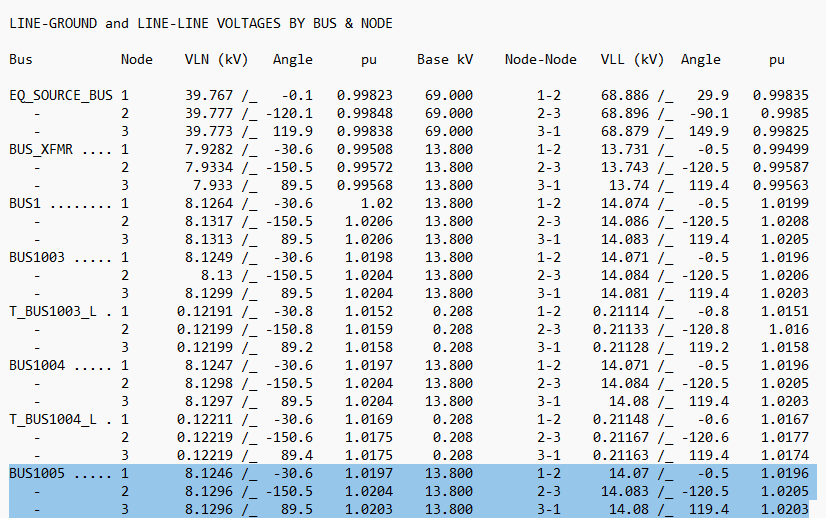  
PLEASE NOTE: In OpenDSS, Node is different from the bus. The node is the connection point of the line, and the bus is the connection point of the transformer.

In [6]:
print("Voltage [PHASE=A] at Bus_1005: ", "Mag = ", snapshot_V_A.loc["bus1005.1", "Mag"],"V; ", "Ang = ", snapshot_V_A.loc["bus1005.1", "Ang"] , "Deg" )
print("Voltage [PHASE=B] at Bus_1005: ", "Mag = ", snapshot_V_B.loc["bus1005.2", "Mag"],"V; ", "Ang = ", snapshot_V_B.loc["bus1005.2", "Ang"] , "Deg" )
print("Voltage [PHASE=C] at Bus_1005: ", "Mag = ", snapshot_V_C.loc["bus1005.3", "Mag"],"V; ", "Ang = ", snapshot_V_C.loc["bus1005.3", "Ang"] , "Deg" )

Voltage [PHASE=A] at Bus_1005:  Mag =  8124.57504961304 V;  Ang =  -30.601762196299 Deg
Voltage [PHASE=B] at Bus_1005:  Mag =  8129.592046585633 V;  Ang =  -150.51573683817062 Deg
Voltage [PHASE=C] at Bus_1005:  Mag =  8129.5618324114275 V;  Ang =  89.45025474816131 Deg


For Lines, we take line "Line_1005_1006" as an example, the snapshot simulation is performed to obtain the power data of the line. The following figure shows the power data from the original OpenDSS using the same sets of data.

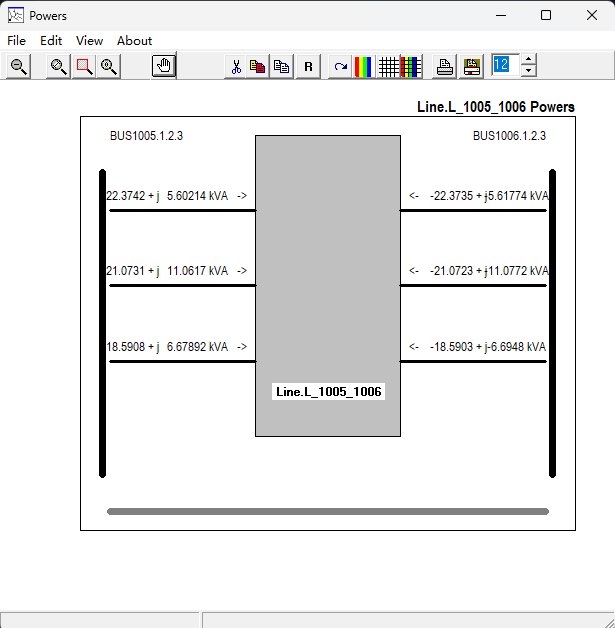


In [7]:
print("Line Power @Bus1 [PHASE=A] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_A.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus1_Imag = ", snapshot_LinePower_A.loc["l_1005_1006", "Bus1_Imag"] , "kVar" )
print("Line Power @Bus2 [PHASE=A] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_A.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus2_Imag = ", snapshot_LinePower_A.loc["l_1005_1006", "Bus2_Imag"] , "kVar" )
print("Line Power @Bus1 [PHASE=B] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_B.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus1_Imag = ", snapshot_LinePower_B.loc["l_1005_1006", "Bus1_Imag"] , "kVar" )
print("Line Power @Bus2 [PHASE=B] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_B.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus2_Imag = ", snapshot_LinePower_B.loc["l_1005_1006", "Bus2_Imag"] , "kVar" )
print("Line Power @Bus1 [PHASE=C] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_C.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus1_Imag = ", snapshot_LinePower_C.loc["l_1005_1006", "Bus1_Imag"] , "kVar" )
print("Line Power @Bus2 [PHASE=C] at l_1005_1006: ", "Bus1_Real = ", snapshot_LinePower_C.loc["l_1005_1006", "Bus1_Real"],"kW; ", "Bus2_Imag = ", snapshot_LinePower_C.loc["l_1005_1006", "Bus2_Imag"] , "kVar" )

Line Power @Bus1 [PHASE=A] at l_1005_1006:  Bus1_Real =  22.374218143341906 kW;  Bus1_Imag =  5.602140537258765 kVar
Line Power @Bus2 [PHASE=A] at l_1005_1006:  Bus1_Real =  22.374218143341906 kW;  Bus2_Imag =  -5.6177416213287925 kVar
Line Power @Bus1 [PHASE=B] at l_1005_1006:  Bus1_Real =  21.073110361225666 kW;  Bus1_Imag =  11.061732542141625 kVar
Line Power @Bus2 [PHASE=B] at l_1005_1006:  Bus1_Real =  21.073110361225666 kW;  Bus2_Imag =  -11.077241243690365 kVar
Line Power @Bus1 [PHASE=C] at l_1005_1006:  Bus1_Real =  18.590786263754158 kW;  Bus1_Imag =  6.678922176389104 kVar
Line Power @Bus2 [PHASE=C] at l_1005_1006:  Bus1_Real =  18.590786263754158 kW;  Bus2_Imag =  -6.694800248626919 kVar


### 2. Time Series Simulation Test

In [8]:
# simulation
Pts_path = "./DSS_Data/Iowa240/ActivePower.csv"
Qts_path = "./DSS_Data/Iowa240/ReactivePower.csv"
Pts_data = pd.read_csv(Pts_path)
Qts_data = pd.read_csv(Qts_path)
Iowa_240Bus_System.set_nodeRecorders()
Iowa_240Bus_System.set_lineRecorders()
Iowa_240Bus_System.set_losses_recorders()
Iowa_240Bus_System.set_regulator_recorders()
List_notConverged = []

total_step = 8760

for time_step in range(0,total_step): # 8760
    for LoadName in Iowa_240Bus_System.df_load.index: # Load allocation
        Iowa_240Bus_System.set_load_P(LoadName,Pts_data.loc[Pts_data.index[time_step],LoadName])
        Iowa_240Bus_System.set_load_Q(LoadName,Qts_data.loc[Qts_data.index[time_step],LoadName])
        
    #TODO Add contigencies here
    
    dss.Solution.Solve() # Solve
    if dss.Solution.Converged()!=1:
        print("The Circuit did not converge")
        List_notConverged.append(time_step)
        continue

    # Collect results
    Iowa_240Bus_System.update_node_recorders()
    Iowa_240Bus_System.update_line_recorders()
    Iowa_240Bus_System.update_losses_recorders()
    Iowa_240Bus_System.update_regulator_recorders()
    sys.stdout.write(f"\rProgress: {time_step+1}/{total_step}")
    sys.stdout.flush()
    pass


Progress: 8760/8760

For performance consideration, we use LIST type to store the data, but we need to convert them to numpy array for further processing.

The performance of this package is compared with the built-in list and the pandas.DataFrame. The following table shows the time consumption of the three methods in the time series simulation of 8760 steps.

| Method | Record Node   | Record Line | Record Loss | Record ALL|
|---------|---------|-----------|---------|---------|
| No Recorders | -  |  - | - | 51.8s |
| Using pd.DataFrame.contact() | 21m 40.3s | NOT TESTED  | 13m 37.1s | >2h |
| Pre Allocating Memory | NOT TESTED  | NOT TESTED  | 9m 17.1s | NOT TESTED |
| Using Build-in List (This Package) | 2m 19s | 1m 48.2s | 1m 14.8s | <u>3m 32.0s</u> |
| Using MATLAB + COM-API | NOT TESTED | NOT TESTED | NOT TESTED | 7m 42.5s|

The tests are carried out on a PC with AMD R7-5700G CPU and 32GB RAM. Matlab approach is provided in https://wzy.ece.iastate.edu/Testsystem.html (Thanks to the authors).

In [9]:
# Save data
nodeV_A = np.array(Iowa_240Bus_System.nodeV_recorder[0])
nodeV_B = np.array(Iowa_240Bus_System.nodeV_recorder[1])
nodeV_C = np.array(Iowa_240Bus_System.nodeV_recorder[2])
IA = np.array(Iowa_240Bus_System.lineCurrent_recorder[0])
IB = np.array(Iowa_240Bus_System.lineCurrent_recorder[1])
IC = np.array(Iowa_240Bus_System.lineCurrent_recorder[2])
PA = np.array(Iowa_240Bus_System.linePower_recorder[0])
PB = np.array(Iowa_240Bus_System.linePower_recorder[1])
PC = np.array(Iowa_240Bus_System.linePower_recorder[2])
Loss = np.array(Iowa_240Bus_System.losses_recorder)
Reg_Tap = np.array(Iowa_240Bus_System.regulator_recorder)

We can save the data using NetCDF4, which is a binary format and can be read by many programming languages. 

In [10]:
with nc.Dataset("E:/Iowa240_1year.nc", "w", format="NETCDF4") as file:
    # Create dimensions
    dim_time = file.createDimension("time", None)
    dim_NodeV_Attribute = file.createDimension("NodeV_Attribute", nodeV_A.shape[2])
    dim_LineCurrent_Attribute = file.createDimension("LineCurrent_Attribute", IA.shape[2])
    dim_LinePower_Attribute = file.createDimension("LinePower_Attribute", PA.shape[2])
    dim_LossAttribute = file.createDimension("LossAttribute", Loss.shape[2])
    dim_node_A = file.createDimension("node_A", nodeV_A.shape[1])
    dim_node_B = file.createDimension("node_B", nodeV_B.shape[1])
    dim_node_C = file.createDimension("node_C", nodeV_C.shape[1])
    dim_line_A = file.createDimension("line_A", IA.shape[1])
    dim_line_B = file.createDimension("line_B", IB.shape[1])
    dim_line_C = file.createDimension("line_C", IC.shape[1])
    dim_element = file.createDimension("element", Loss.shape[1])
    dim_regulator = file.createDimension("regulator", Reg_Tap.shape[1])
    
    # Create variables
    Node_V_A = file.createVariable("Node_V_A", "f4", ("time", "node_A", "NodeV_Attribute"))
    Node_V_B = file.createVariable("Node_V_B", "f4", ("time", "node_B", "NodeV_Attribute"))
    Node_V_C = file.createVariable("Node_V_C", "f4", ("time", "node_C", "NodeV_Attribute"))
    Line_I_A = file.createVariable("Line_I_A", "f4", ("time", "line_A", "LineCurrent_Attribute"))
    Line_I_B = file.createVariable("Line_I_B", "f4", ("time", "line_B", "LineCurrent_Attribute"))
    Line_I_C = file.createVariable("Line_I_C", "f4", ("time", "line_C", "LineCurrent_Attribute"))
    Line_PQ_A = file.createVariable("Line_PQ_A", "f4", ("time", "line_A", "LinePower_Attribute"))
    Line_PQ_B = file.createVariable("Line_PQ_B", "f4", ("time", "line_B", "LinePower_Attribute"))
    Line_PQ_C = file.createVariable("Line_PQ_C", "f4", ("time", "line_C", "LinePower_Attribute"))
    Element_Loss = file.createVariable("Element_Loss", "f4", ("time", "element", "LossAttribute"))
    Regulator_Tap = file.createVariable("Regulator_Tap", "i1", ("time", "regulator"))
    
    Node_Name_A = file.createVariable("Node_Name_A", "U", ("node_A"))
    Node_Name_B = file.createVariable("Node_Name_B", "U", ("node_B"))
    Node_Name_C = file.createVariable("Node_Name_C", "U", ("node_C"))
    Line_Name_A = file.createVariable("Line_Name_A", "U", ("line_A"))
    Line_Name_B = file.createVariable("Line_Name_B", "U", ("line_B"))
    Line_Name_C = file.createVariable("Line_Name_C", "U", ("line_C"))
    Element_Name = file.createVariable("Element_Name", "U", ("element"))
    Regulator_Name = file.createVariable("Regulator_Name", "U", ("regulator"))

    
    # Write data
    Node_V_A [:,:,:] = nodeV_A
    Node_V_B [:,:,:] = nodeV_B
    Node_V_C [:,:,:] = nodeV_C
    Line_I_A [:,:,:] = IA
    Line_I_B [:,:,:] = IB
    Line_I_C [:,:,:] = IC
    Line_PQ_A [:,:,:] = PA
    Line_PQ_B [:,:,:] = PB
    Line_PQ_C [:,:,:] = PC
    Element_Loss [:,:,:] = Loss
    Regulator_Tap [:,:] = Reg_Tap
    
    Node_Name_A[:] = np.array(Iowa_240Bus_System.list_nodeName[0])
    Node_Name_B[:] = np.array(Iowa_240Bus_System.list_nodeName[1])
    Node_Name_C[:] = np.array(Iowa_240Bus_System.list_nodeName[2])
    Line_Name_A[:] = np.array(Iowa_240Bus_System.list_lineName[0])
    Line_Name_B[:] = np.array(Iowa_240Bus_System.list_lineName[1])
    Line_Name_C[:] = np.array(Iowa_240Bus_System.list_lineName[2])
    Element_Name[:] = np.array(dss.Circuit.AllElementNames())
    Regulator_Name[:] = np.array(dss.RegControls.AllNames())

We can also read netcdf files using python, and the following code shows how to read the netcdf file.


In [11]:
# read data from netcdf file
with nc.Dataset("E:/Iowa240_1year.nc", "r") as file:
    Node_V_A = file.variables["Node_V_A"][:]
    Node_V_B = file.variables["Node_V_B"][:]
    Node_V_C = file.variables["Node_V_C"][:]
    Line_I_A = file.variables["Line_I_A"][:]
    Line_I_B = file.variables["Line_I_B"][:]
    Line_I_C = file.variables["Line_I_C"][:]
    Line_PQ_A = file.variables["Line_PQ_A"][:]
    Line_PQ_B = file.variables["Line_PQ_B"][:]
    Line_PQ_C = file.variables["Line_PQ_C"][:]
    Element_Loss = file.variables["Element_Loss"][:]
    Regulator_Tap = file.variables["Regulator_Tap"][:]
    Node_Name_A = file.variables["Node_Name_A"][:]
    Node_Name_B = file.variables["Node_Name_B"][:]
    Node_Name_C = file.variables["Node_Name_C"][:]
    Line_Name_A = file.variables["Line_Name_A"][:]
    Line_Name_B = file.variables["Line_Name_B"][:]
    Line_Name_C = file.variables["Line_Name_C"][:]
    Element_Name = file.variables["Element_Name"][:]
    Regulator_Name = file.variables["Regulator_Name"][:]


Now we visualize some data using matplotlib.

First, we show one-year active and reactive power consumption at the main substation transformer (EQ_SOURCE_BUS), which can be obtained from the first element in the loss defined in OpenDSSDirect.

The following figure shows results cited from the slides of EE653 @Iowa State University (https://wzy.ece.iastate.edu/EE653.html), which used the official OpenDSS Matlab API.

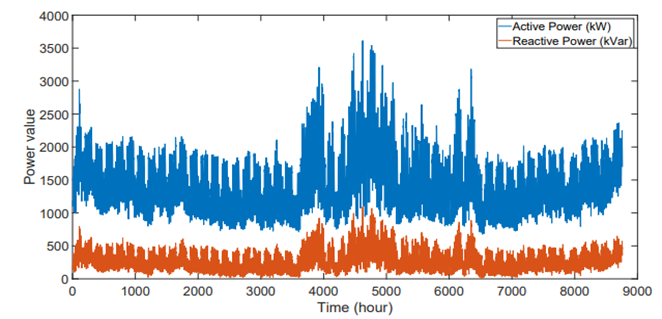

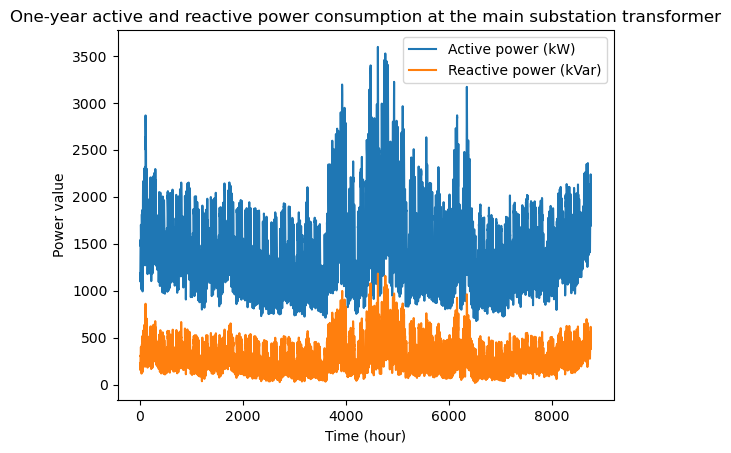

In [12]:
plt.plot(-Element_Loss[:,0,0], label = "Active power (kW)") # attention: the sign of power is negative
plt.plot(-Element_Loss[:,0,1], label = "Reactive power (kVar)")
plt.title("One-year active and reactive power consumption at the main substation transformer")
plt.xlabel("Time (hour)")
plt.ylabel("Power value")
plt.legend()
plt.show()     

Next, we show the voltage profile of distributions of one-year nodal voltages of Feeder C (phase A). The following figure is cited from the slides of EE653.

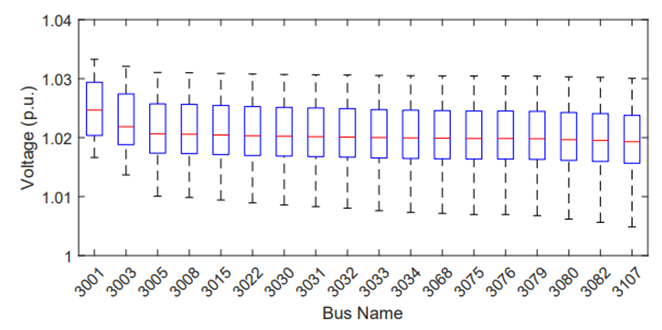


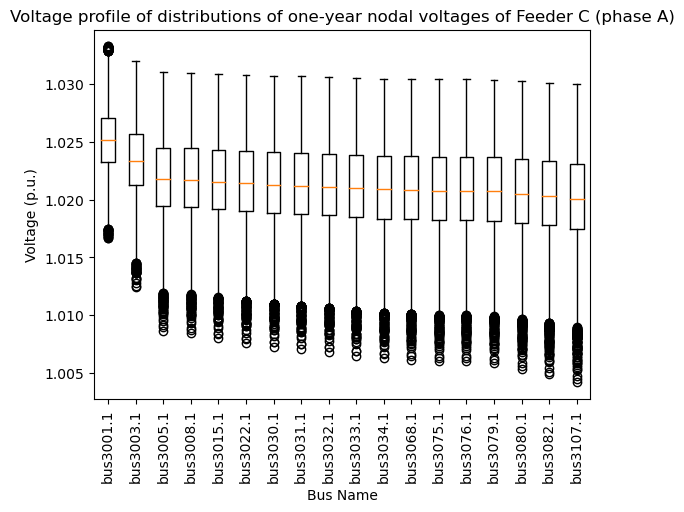

In [13]:
Bus_List = ["bus3001.1","bus3003.1","bus3005.1","bus3008.1","bus3015.1","bus3022.1","bus3030.1",
            "bus3031.1","bus3032.1","bus3033.1","bus3034.1","bus3068.1","bus3075.1","bus3076.1"
            ,"bus3079.1","bus3080.1","bus3082.1","bus3107.1"]

Bus_Index = []
for i in range(len(Bus_List)):
    Bus_Index.append(np.where(Node_Name_A == Bus_List[i])[0][0])
    
Bus_VPU_A = Node_V_A[:,Bus_Index,4]

plt.boxplot(Bus_VPU_A, labels = Bus_List)
plt.xlabel("Bus Name")
plt.ylabel("Voltage (p.u.)")
plt.xticks(rotation=90)
plt.title("Voltage profile of distributions of one-year nodal voltages of Feeder C (phase A)")

plt.show()

Finally, we study the VVO results, and give the tap positions and voltage magnitudes at Bus 1 (phase A). The following figure is cited from the slides of EE653. Please note that there is difference between the results of this package and the official OpenDSS Matlab API. The reason may be the different data used in the simulation. However, you can see that the tap positions track the voltage magnitudes.

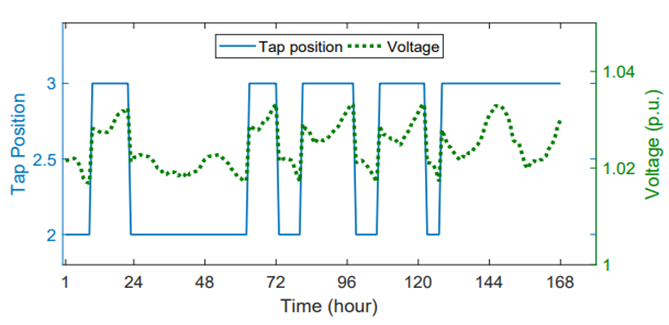

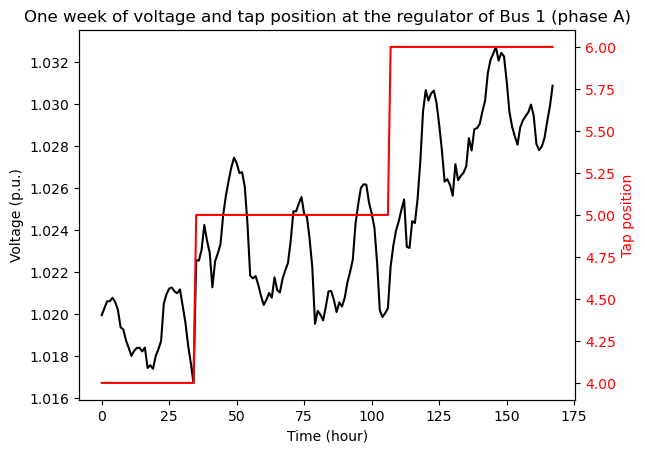

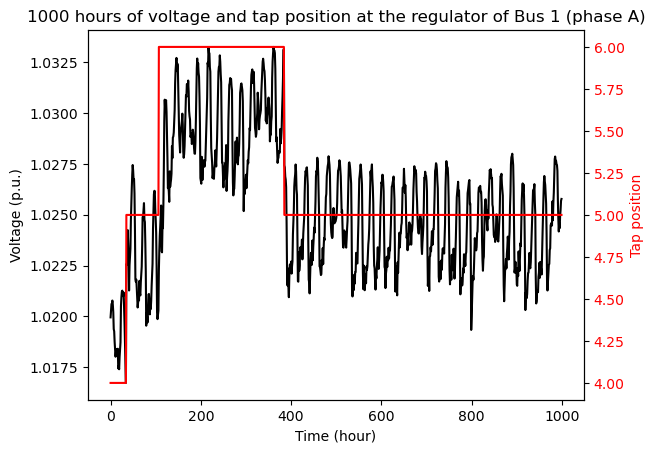

In [14]:
fig1, ax11 = plt.subplots()
ax11.plot(Node_V_A[0:168,2,4], color='k')
ax11.set_xlabel('Time (hour)')
ax11.set_ylabel('Voltage (p.u.)')
ax21 = ax11.twinx()
ax21.plot(Regulator_Tap[0:168,0], color = "red")
ax21.set_ylabel('Tap position', color = "red")
ax21.tick_params(axis='y', labelcolor="red")
plt.title("One week of voltage and tap position at the regulator of Bus 1 (phase A)")
plt.show()


fig2, ax12 = plt.subplots()
ax12.plot(Node_V_A[0:1000,2,4], color='k')
ax12.set_xlabel('Time (hour)')
ax12.set_ylabel('Voltage (p.u.)')
ax22 = ax12.twinx()
ax22.plot(Regulator_Tap[0:1000,0], color = "red")
ax22.set_ylabel('Tap position', color = "red")
ax22.tick_params(axis='y', labelcolor="red")
plt.title("1000 hours of voltage and tap position at the regulator of Bus 1 (phase A)")
plt.show()

### 3. Topology 


You can use the following code to get the currently physical topology of the system. We use the Iowa 240-Bus system as an example. The following two figures shows the topology of the system in SCADA and OpenDSS, respectively.

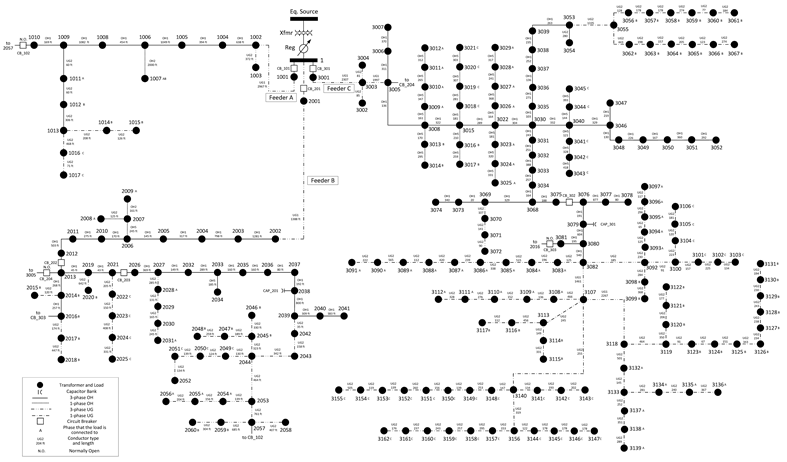

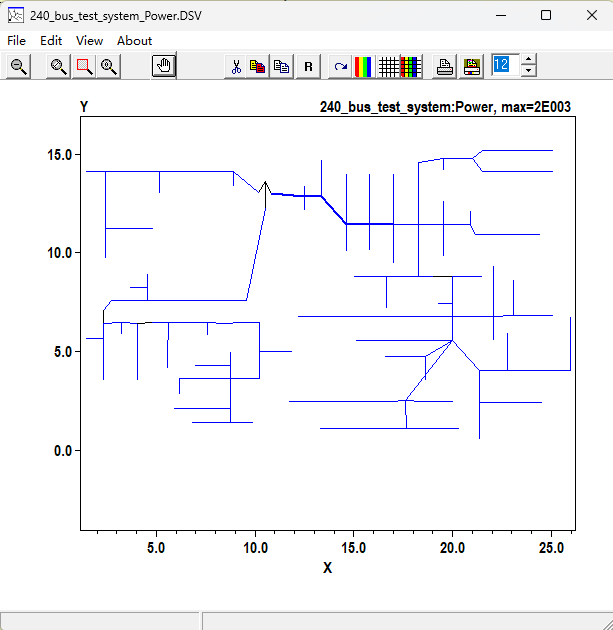

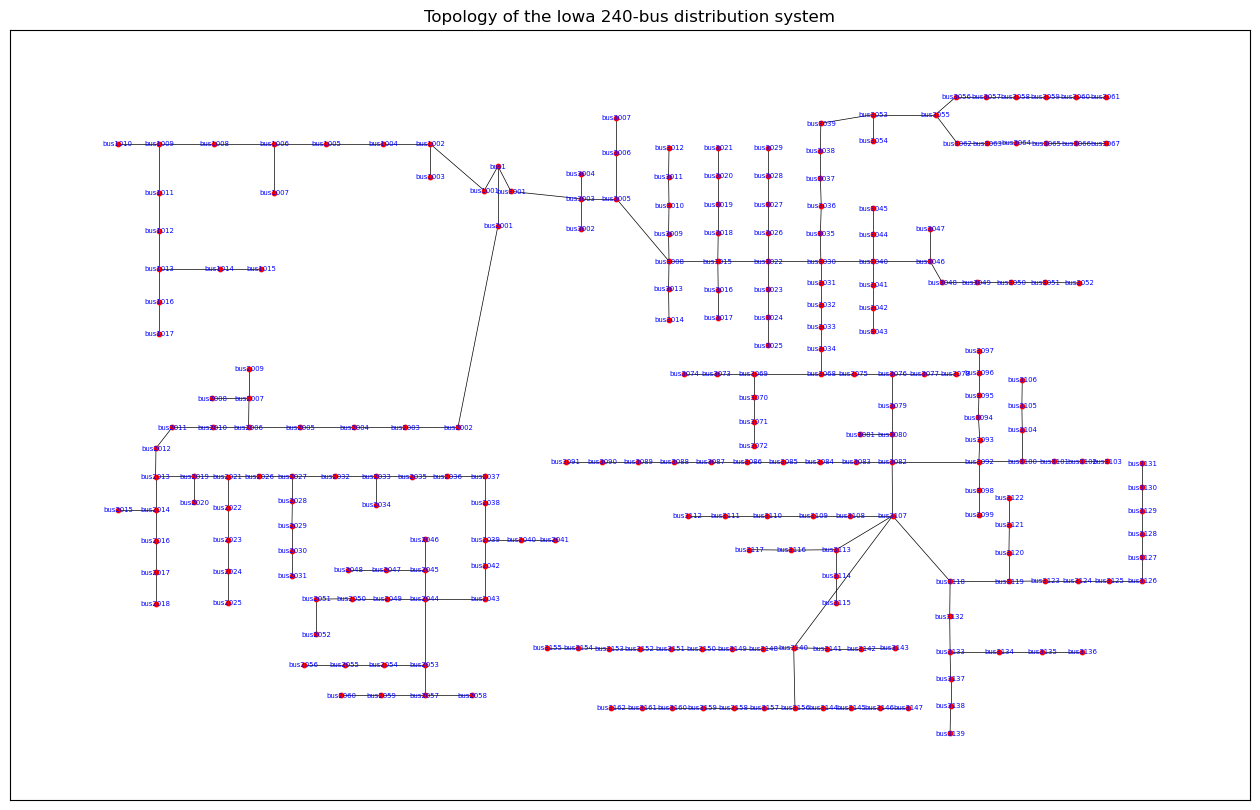

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(16, 10))
ax = axs
G, pos= Iowa_240Bus_System.create_graph_by_phase(phase=0) # Note that phase=0 means 3-phase system
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color="red")
nx.draw_networkx_labels(G, pos, font_size=5, font_color="blue")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black", width=0.5)
plt.title("Topology of the Iowa 240-bus distribution system")
plt.show()

Actually, the three-phases system can be considered as three single-phase systems. You can also plot single-phase topology using the following code.

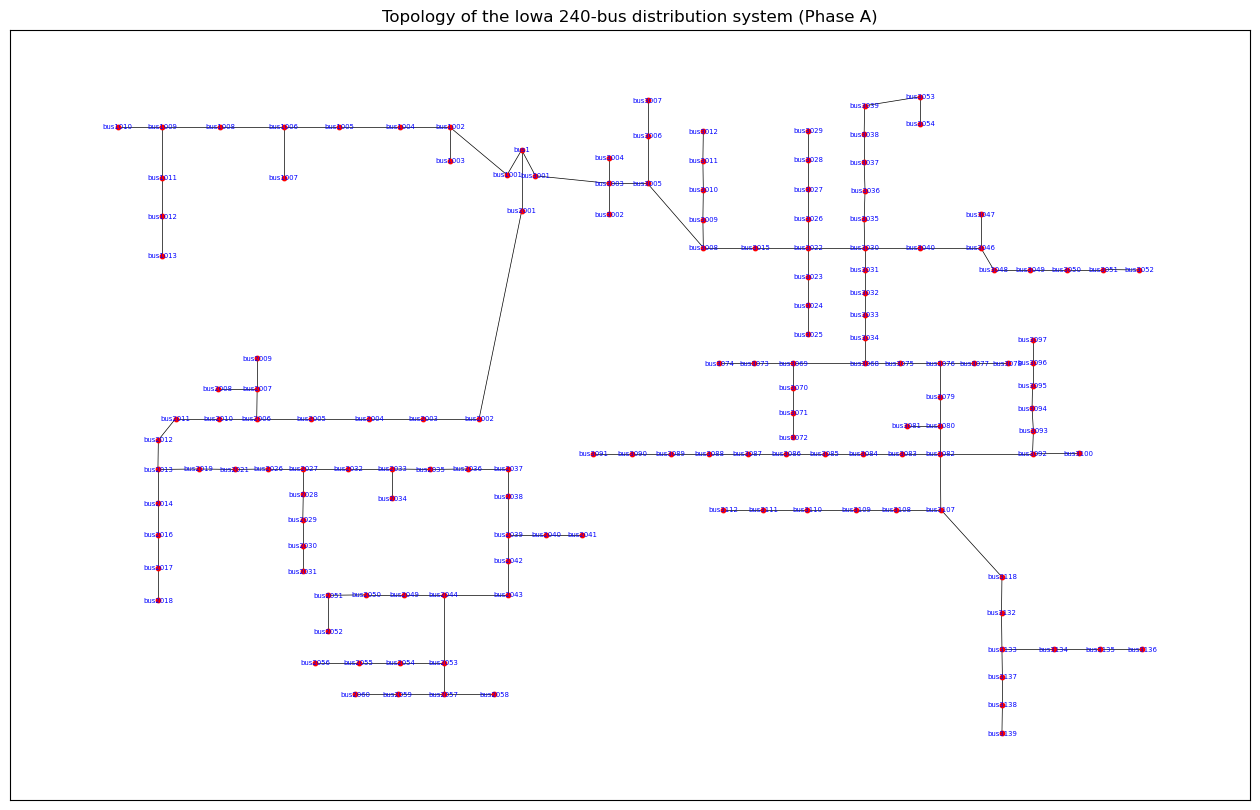

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(16, 10))
ax = axs
G, pos= Iowa_240Bus_System.create_graph_by_phase(phase=1) # Note that phase=1 means phase-A
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color="red")
nx.draw_networkx_labels(G, pos, font_size=5, font_color="blue")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black", width=0.5)
plt.title("Topology of the Iowa 240-bus distribution system (Phase A)")
plt.show()

We can remove some edges to simulate the topology change, which is common in researches in resilient distribution system. For example, if you want to remove the line between bus2001 and bus2002 (i.e., l_2001_2002), the DSS script is: 
* Open Line.l_2001_2002, if for all phases
* Open Line.l_2001_2002 1(or 2) 1~3, if for phase A~B

In python, you can use the following code to remove the edge and run the simulation.

In [17]:
Iowa_240Bus_System = DSS_Model(main_file_path=dss_path)
P = G.copy()
P.remove_edges_from([("bus2001","bus2002")])
"""nx:diff(G,P) -> df:removed edge -> dss:switch operation """
diff = nx.to_pandas_edgelist(nx.difference(G,P)) # nx:diff(G,P)
removed_edge = Iowa_240Bus_System.line_graph_data.loc[(Iowa_240Bus_System.line_graph_data['Bus1'].isin(diff['source'])) & (Iowa_240Bus_System.line_graph_data['Bus2'].isin(diff['target'])) ] # df:removed edge
print("Before: switch open at this phase?",dss.CktElement.IsOpen(0,1)) # See OpenDSS official doc. "OpenDSSComDoc" : CktElement
Iowa_240Bus_System.open_switches_by_phase(removed_edge,phase=1) # dss:switch operation
dss.Circuit.SetActiveElement("Line.l_2001_2002")
print("After: switch open at this phase?", dss.CktElement.IsOpen(0,1))

Before: switch open at this phase? False
After: switch open at this phase? True


You can analyze the voltage and power situation in the variable list yourself.

In [18]:

dss.Solution.Solve()
VA_Removed = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(1))
VA_Removed.index = Node_Name_A
VA_Removed.columns = ["Real","Imag","Mag","Ang"]
VB_Removed = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(2))
VB_Removed.index = Node_Name_B
VB_Removed.columns = ["Real","Imag","Mag","Ang"]
VC_Removed = pd.DataFrame(Iowa_240Bus_System.read_AllNodeVoltage_by_phase(3))
VC_Removed.index = Node_Name_C
VC_Removed.columns = ["Real","Imag","Mag","Ang"]
